### Import modules

In [1]:
###
# Gestion de données
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle

# Visualisations

import plotly.express as px
from PIL import Image
from IPython.display import display
###
# Core

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np


from utils.utils import new_distrib
###
# Acceleration matérielle

from tensorflow.keras import mixed_precision

# mixed_precision.set_global_policy(
#     mixed_precision.Policy('mixed_float16'))
tf.config.optimizer.set_jit(True)

2022-10-25 01:32:19.143854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 01:32:19.763001: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-25 01:32:21.094316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2022-10-25 01:32:21.094459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or

### Preparation du Dataloader
#### Constantes

In [40]:
batch_size = 8
img_height = 224
img_width = 224
num_classes = 4

In [4]:
import random

In [41]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        width_shift_range=15.0,
        height_shift_range=15.0,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=(0.7,1.0),
        brightness_range=(0.7,1),
    preprocessing_function=lambda x:tfa.image.equalize(np.array(x))
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=lambda x:tfa.image.equalize(np.array(x)))

train_ds = train_datagen.flow_from_directory(
    directory='DATA/Train',
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    interpolation='nearest',
    keep_aspect_ratio=True
)

test_ds = test_datagen.flow_from_directory(
    'DATA/Test',
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    interpolation='nearest',
    keep_aspect_ratio=True
)

Found 7556 images belonging to 4 classes.
Found 1890 images belonging to 4 classes.


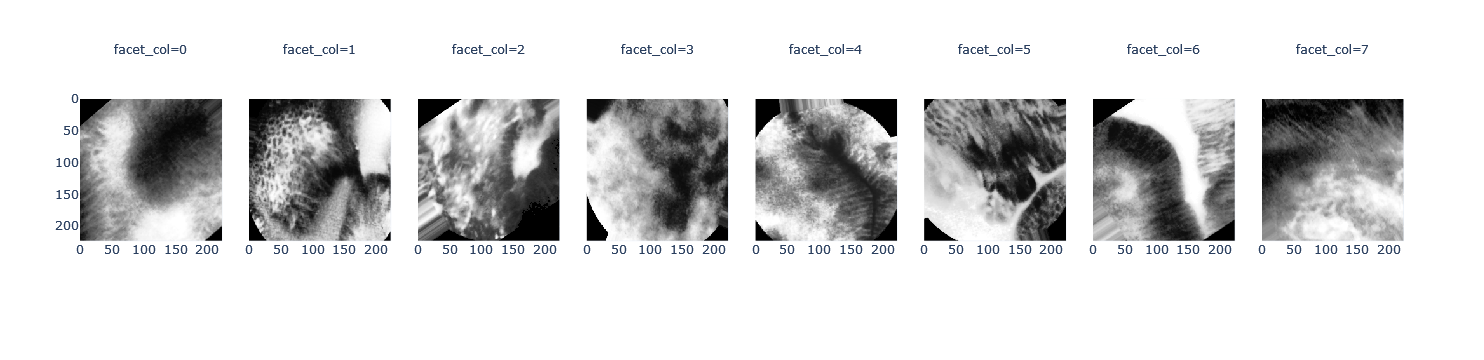

In [45]:
px.imshow(next(train_ds)[0],facet_col=0)

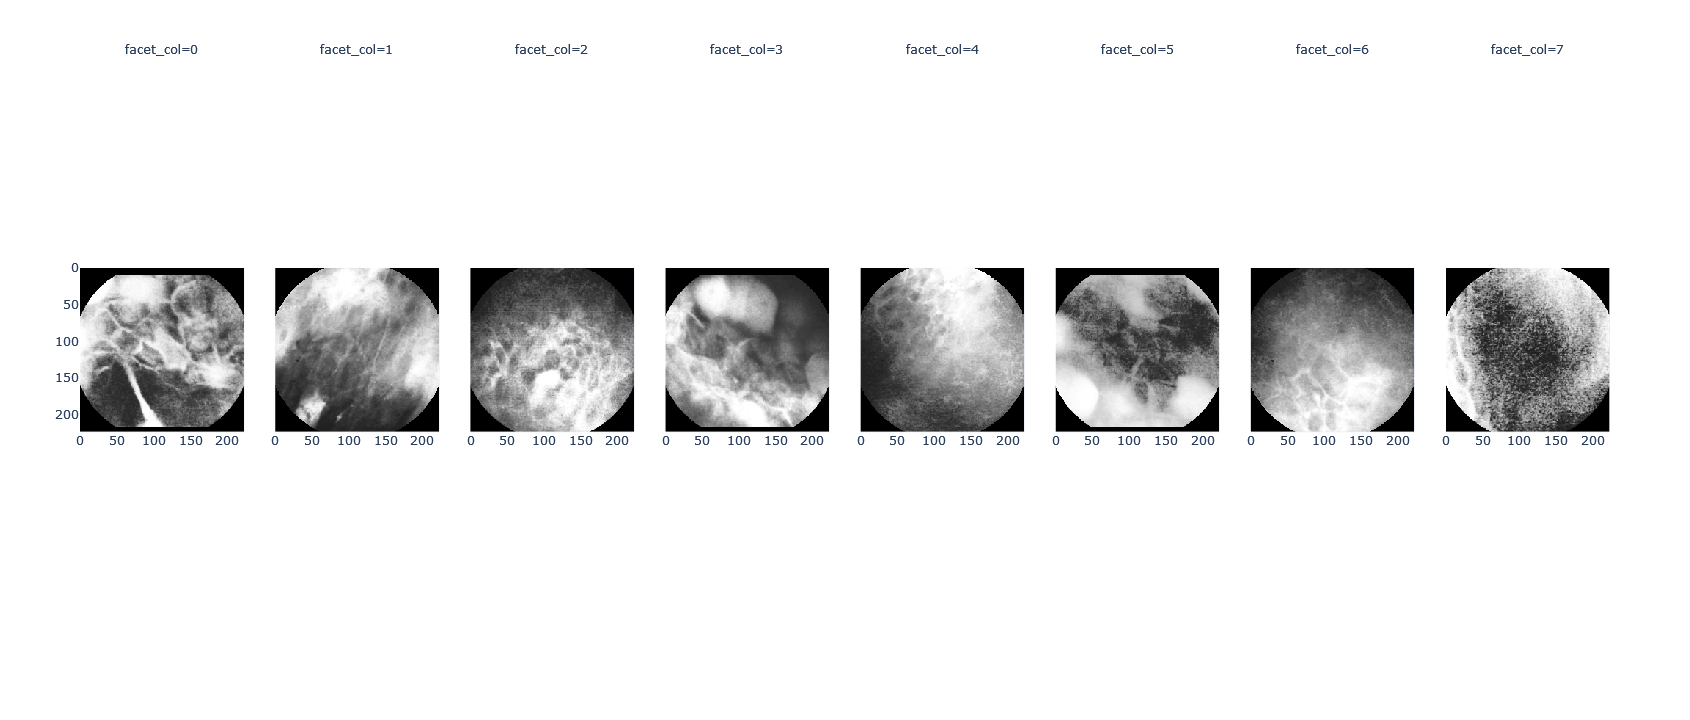

In [44]:
px.imshow(next(test_ds)[0],facet_col=0)

### Ecriture du modèle

In [47]:
####
# If you want Efficientnet

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.applications.inception_v3.InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=(img_height, img_width,3),
        pooling='avg',
        # include_preprocessing=True
        classes=1000,

    ),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Softmax()
])

####
# If you want DenseNet

# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.applications.densenet.DenseNet169(
#         include_top=True,
#         weights="imagenet",
#         input_shape=(img_height, img_width,3),
#         pooling='avg',
#     #classes=num_classes,
# ),
#     tf.keras.layers.Dense(250,activation='relu'),
#     tf.keras.layers.Dense(num_classes),
#     tf.keras.layers.Softmax()
# ])

##
# If you want simple CNN

# model = tf.keras.models.Sequential([
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     # tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(num_classes,activation = 'softmax')])




# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.applications.convnext.ConvNeXtSmall(
#         include_top=False,
#         model_name='convnext_xlarge',
#         include_preprocessing=True,
#         weights='imagenet',
#         input_tensor=None,
#         input_shape=(img_height, img_width,3),
#         pooling='avg',
#         classes=num_classes,
#     ),
#    tf.keras.layers.Dense(num_classes),
#     tf.keras.layers.Softmax()
# ])


In [125]:
## model=tf.keras.models.load_model('models')

In [1]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6007

In [48]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'IV3',
    monitor = 'val_loss',
    mode = 'auto',
    save_freq='epoch',
)
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='logs_IV3',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)
cbs = [checkpoint,tensorboard]

In [ ]:
model=tf.keras.models.load_model('DenseNet121')

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy','AUC'])

In [ ]:
epochs=20
with tf.device('GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
        callbacks=cbs
    )

Epoch 1/20


2022-10-25 02:13:28.700705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:5025] Disabling cuDNN frontend for the following convolution:
  input: {count: 8 feature_map_count: 320 spatial: 5 5  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 2048 input_feature_map_count: 320 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2022-10-25 02:13:28.709554: I tensorflow/stream_executor/cuda/cuda_dnn.cc:5025] Disabling cuDNN frontend for the following convolution:
  input: {count: 8 feature_map_count: 448 spatial: 5 5  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 2048 input_feature_map_count: 448 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2022-10-25 0

945/945 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.6964 - auc: 0.8916

2022-10-25 02:19:31.973917: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_13', 24 bytes spill stores, 60 bytes spill loads



INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 457s 391ms/step - loss: 0.8165 - accuracy: 0.6964 - auc: 0.8916 - val_loss: 0.5739 - val_accuracy: 0.8048 - val_auc: 0.9506
Epoch 2/20
227/945 [======>.......................] - ETA: 3:31 - loss: 0.5682 - accuracy: 0.7874 - auc: 0.9456

2022-10-25 02:22:57.774534: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_1935', 884 bytes spill stores, 404 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_1936', 3788 bytes spill stores, 400 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_347', 388 bytes spill stores, 388 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_896', 3856 bytes spill stores, 4116 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_957', 2764 bytes spill stores, 2772 bytes spill loads



945/945 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.8061 - auc: 0.9527

2022-10-25 02:27:35.494306: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_13', 28 bytes spill stores, 52 bytes spill loads



INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 439s 464ms/step - loss: 0.5263 - accuracy: 0.8061 - auc: 0.9527 - val_loss: 0.4637 - val_accuracy: 0.8296 - val_auc: 0.9647
Epoch 3/20
945/945 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8325 - auc: 0.9637

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 380s 402ms/step - loss: 0.4571 - accuracy: 0.8325 - auc: 0.9637 - val_loss: 0.3926 - val_accuracy: 0.8561 - val_auc: 0.9734
Epoch 4/20
945/945 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8546 - auc: 0.9737

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 381s 403ms/step - loss: 0.3891 - accuracy: 0.8546 - auc: 0.9737 - val_loss: 0.3042 - val_accuracy: 0.8947 - val_auc: 0.9837
Epoch 5/20
945/945 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8703 - auc: 0.9766

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 381s 403ms/step - loss: 0.3632 - accuracy: 0.8703 - auc: 0.9766 - val_loss: 0.2713 - val_accuracy: 0.9106 - val_auc: 0.9868
Epoch 6/20
945/945 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8756 - auc: 0.9797

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 384s 406ms/step - loss: 0.3387 - accuracy: 0.8756 - auc: 0.9797 - val_loss: 0.2620 - val_accuracy: 0.9111 - val_auc: 0.9871
Epoch 7/20
945/945 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8830 - auc: 0.9823

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 386s 408ms/step - loss: 0.3141 - accuracy: 0.8830 - auc: 0.9823 - val_loss: 0.2356 - val_accuracy: 0.9164 - val_auc: 0.9896
Epoch 8/20
945/945 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.8920 - auc: 0.9844

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 380s 402ms/step - loss: 0.2929 - accuracy: 0.8920 - auc: 0.9844 - val_loss: 0.2080 - val_accuracy: 0.9280 - val_auc: 0.9922
Epoch 9/20
945/945 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9111 - auc: 0.9873

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 380s 402ms/step - loss: 0.2590 - accuracy: 0.9111 - auc: 0.9873 - val_loss: 0.1953 - val_accuracy: 0.9323 - val_auc: 0.9927
Epoch 10/20
945/945 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9087 - auc: 0.9878

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 389s 411ms/step - loss: 0.2559 - accuracy: 0.9087 - auc: 0.9878 - val_loss: 0.1705 - val_accuracy: 0.9439 - val_auc: 0.9944
Epoch 11/20
945/945 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9142 - auc: 0.9890

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 392s 414ms/step - loss: 0.2430 - accuracy: 0.9142 - auc: 0.9890 - val_loss: 0.1574 - val_accuracy: 0.9487 - val_auc: 0.9947
Epoch 12/20
945/945 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9217 - auc: 0.9896

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 388s 410ms/step - loss: 0.2292 - accuracy: 0.9217 - auc: 0.9896 - val_loss: 0.1739 - val_accuracy: 0.9508 - val_auc: 0.9929
Epoch 13/20
945/945 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9276 - auc: 0.9917

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 386s 409ms/step - loss: 0.2101 - accuracy: 0.9276 - auc: 0.9917 - val_loss: 0.1724 - val_accuracy: 0.9450 - val_auc: 0.9928
Epoch 14/20
945/945 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9280 - auc: 0.9913

INFO:tensorflow:Assets written to: IV3/assets


INFO:tensorflow:Assets written to: IV3/assets


945/945 [==============================] - 406s 429ms/step - loss: 0.2138 - accuracy: 0.9280 - auc: 0.9913 - val_loss: 0.1588 - val_accuracy: 0.9529 - val_auc: 0.9939
Epoch 15/20
622/945 [==================>...........] - ETA: 4:52 - loss: 0.1907 - accuracy: 0.9393 - auc: 0.9931

In [83]:
test = pd.read_csv('untitled.txt')
val_datagen = ImageDataGenerator(
        rescale=1./255,)

vset = val_datagen.flow_from_dataframe(
    test,
    directory='DATA/TestSetImages/TestSetImagesDir/part_1',
    x_col='image_filename',
    y_col='image_filename',
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=None,
    interpolation='nearest',
    keep_aspect_ratio=True
)


In [110]:
res = model.predict(vset)
test['class_number'] = np.argmax(res,axis=1)
test.to_csv('res.csv',index=False)

108/108 [==============================] - 11s 95ms/step
